# Mathematical Finance Case 2: Black-Scholes Formula for Unit-Linked Contract

## Problem Parameters

We use the following parameters for all parts:

$$
r = 1\% = 0.01, \quad \sigma = 15\% = 0.15, \quad T = 10, \quad G = 100, \quad S_0 = 100.
$$

---

## Question 1 – Closed-Form Analytical Price (Joshi §6.8 / Slide 18)

### Risk-Neutral Dynamics

Under the risk-neutral measure $\mathbb{Q}$,

$$
S_T = S_0\, \exp\!\left( (r - \tfrac{1}{2}\sigma^2)T + \sigma\sqrt{T}\, Z \right), \qquad Z \sim N(0,1).
$$

### Payoff

The payoff of the unit-linked contract with guarantee $G$ is

$$
F(T,Z) = \max\{S_T, G\}, \qquad G = 100.
$$

### Valuation at $t=0$

$$
V_0 = e^{-rT}\, \mathbb{E}^{\mathbb{Q}}\big[\max(S_T, G)\big].
$$

Let $z^* = \ln G$ and define

$$
\phi(z) = \frac{1}{\sqrt{2\pi v}}\,\exp\!\left( -\frac{(z-m)^2}{2v} \right),
\quad m = \ln S_0 + (r - \tfrac{1}{2}\sigma^2)T,\quad v = \sigma^2 T.
$$

Split the integral:

$$
V_0 = e^{-rT}\!\left( \int_{z^*}^{\infty} e^{z}\,\phi(z)\,dz \; + \; \int_{-\infty}^{z^*} G\,\phi(z)\,dz \right).
$$

Evaluating both parts gives

$$
V_0 = S_0\,\Phi(d_1) + G\,e^{-rT}\,\Phi(-d_2),
$$

with

$$
d_1 = \frac{\ln(S_0/G) + (r + \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}, \qquad
d_2 = d_1 - \sigma\sqrt{T}.
$$

Plugging in $S_0=G=100$, $r=0.01$, $\sigma=0.15$, $T=10$:

$$
\begin{aligned}
 d_1 &= \frac{(0.01 + 0.5\times 0.15^2)\times 10}{0.15\sqrt{10}} = \frac{0.2125}{0.47434} \approx 0.44798,\\
 d_2 &= 0.44798 - 0.47434 \approx -0.02636.
\end{aligned}
$$

Moreover,

$$
\Phi(d_1)\approx 0.6729,\qquad \Phi(-d_2)=\Phi(0.02636)\approx 0.5105,\qquad e^{-rT}=e^{-0.1}\approx 0.90484.
$$

Therefore,

$$
\Rightarrow\quad V_0 = 100(0.6729) + 100\, e^{-0.01\times 10}(0.5105)
\approx 67.29 + 46.19 \approx 113.48.
$$

So the analytical price of the contract is approximately $\mathbf{113.48}$.

---

## Question 2 – Convergence of the Binomial Tree (Formulas used in our graph)

We compare the binomial price against the analytical reference using the R-embedded lattice (the one used to produce the dotted “wiggles” plot).

One-step parameters for $\Delta t = T/N$:

$$
R = e^{r\,\Delta t}, \qquad u = R\,e^{\sigma\sqrt{\Delta t}}, \qquad d = R\,e^{-\sigma\sqrt{\Delta t}}, \qquad p = \frac{R - d}{u - d}.
$$

Terminal stock and payoff:

$$
S_{N,k} = S_0\,u^{\,k}\,d^{\,N-k}, \qquad V_{N,k} = \max(S_{N,k}, G).
$$

Backward induction (risk‑neutral valuation):

$$
V_{i,j} = \frac{p\,V_{i+1,j+1} + (1-p)\,V_{i+1,j}}{R}.
$$

Reference analytical value (red dashed line in the figure):

$$
V_0^{\text{BS}} = S_0\,\Phi(d_1) + G\,e^{-rT}\,\Phi(-d_2).
$$

In the figure we plot $V_0^{(N)}$ for $N=4,5,\dots,100$ together with the horizontal line at $V_0^{\text{BS}}\approx 113.48$.

---

## Question 2 – Convergence of the Binomial Tree (Code)

We implement the R‑embedded binomial lattice used for the plot:

- $\Delta t = T/N$, $R=e^{r\Delta t}$
- $u = R\,e^{\sigma\sqrt{\Delta t}},\; d = R\,e^{-\sigma\sqrt{\Delta t}}$
- $p = (R-d)/(u-d)$
- Terminal: $V_{N,k}=\max(S_0 u^k d^{N-k}, G)$
- Backward: $V_{i,j} = (p V_{i+1,j+1} + (1-p) V_{i+1,j})/R$

The red dashed line corresponds to the analytical price $V_0^{\text{BS}} = S_0\,\Phi(d_1) + G\,e^{-rT}\,\Phi(-d_2)$ with the parameters shown in Question 1.

### Variant: Tree with R embedded in up/down factors

Some earlier materials used a variant where the one‑step factors include the risk‑free growth:

- u = R · exp(σ√Δt),  d = R · exp(−σ√Δt),  with R = e^{rΔt}.
- p = (R − d) / (u − d).

This alters terminal stock nodes (they get an extra R^N scaling) and can change the shape of the convergence curve compared with the standard CRR choice u=exp(σ√Δt), d=1/u. Below we reproduce that variant to compare.

In [1]:
def price_binomial_embedR(S0: float, G: float, r: float, sigma: float, T: float, N: int) -> float:
    """Binomial price where u and d include the risk‑free growth factor R per step.
    u = R*exp(σ√Δt), d = R*exp(−σ√Δt); p = (R − d)/(u − d)."""
    if N <= 0:
        return max(S0, G)
    dt = T / N
    R = math.exp(r * dt)
    u = R * math.exp(sigma * math.sqrt(dt))
    d = R * math.exp(-sigma * math.sqrt(dt))
    p = (R - d) / (u - d)
    if not (0.0 < p < 1.0):
        raise ValueError(f"Risk‑neutral probability out of bounds: p={p:.6f}.")
    k = np.arange(N + 1)
    ST = S0 * (u ** k) * (d ** (N - k))
    f = np.maximum(ST, G)
    for _ in range(N):
        f = (p * f[1:] + (1.0 - p) * f[:-1]) / R
    return float(f[0])

Saved wiggles_plot.png


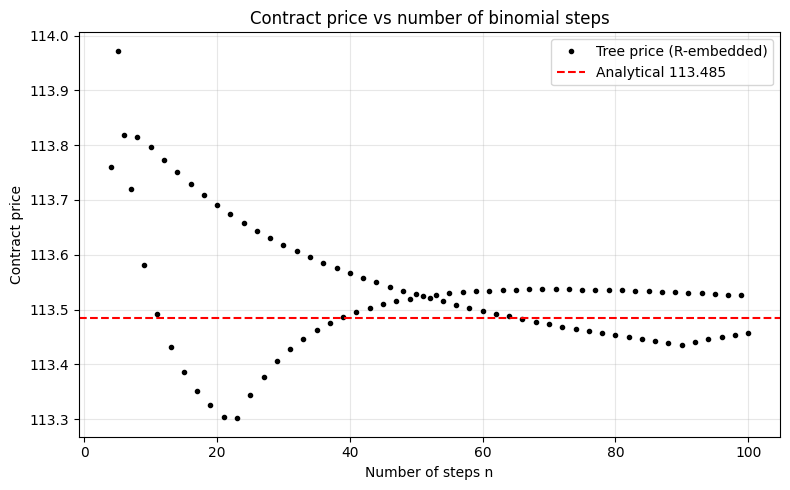

In [6]:
# Wiggles plot (R-embedded binomial) with analytical reference line + save to PNG
import numpy as np, matplotlib.pyplot as plt
S0 = 100.0; G = 100.0; r = 0.01; sigma = 0.15; T = 10.0
N_small = np.arange(4, 101, 1)
# price_binomial_embedR and bs_unit_linked_price assumed defined previously
if 'price_binomial_embedR' not in globals():
    raise RuntimeError('Function price_binomial_embedR not defined before this cell.')
if 'bs_unit_linked_price' not in globals():
    raise RuntimeError('Function bs_unit_linked_price not defined before this cell.')
tree_prices_embedR = np.array([price_binomial_embedR(S0, G, r, sigma, T, int(n)) for n in N_small])
bs_ref = bs_unit_linked_price(S0, G, r, sigma, T)
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(N_small, tree_prices_embedR, 'k.', label='Tree price (R-embedded)')
ax.axhline(bs_ref, color='red', linestyle='--', label=f'Analytical {bs_ref:.3f}')
ax.set_xlabel('Number of steps n')
ax.set_ylabel('Contract price')
ax.set_title('Contract price vs number of binomial steps')
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig('wiggles_plot.png', dpi=200)
print('Saved wiggles_plot.png')

In [3]:
# Imports and analytical function  for Question 2
import numpy as np
import math
import matplotlib.pyplot as plt

def cdf_norm(x: float) -> float:
    """Standard normal CDF via error function (no SciPy dependency)."""
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def bs_unit_linked_price(S0: float, G: float, r: float, sigma: float, T: float) -> float:
    """Analytical value: E[ max(S_T, G) ] discounted at r under Black–Scholes.
    This equals S0 * N(d1) + G * exp(-rT) * N(-d2)."""
    if T <= 0:
        return max(S0, G)
    vol_sqrt_T = sigma * math.sqrt(T)
    d1 = (math.log(S0 / G) + (r + 0.5 * sigma * sigma) * T) / (vol_sqrt_T)
    d2 = d1 - vol_sqrt_T
    return S0 * cdf_norm(d1) + G * math.exp(-r * T) * cdf_norm(-d2)

N=1000  tree=113.488150  |error|=0.003174
N=2000  tree=113.486265  |error|=0.001288
N=3000  tree=113.485504  |error|=0.000528
N=4000  tree=113.485774  |error|=0.000798
N=5000  tree=113.485788  |error|=0.000812
N=6000  tree=113.485024  |error|=0.000048
N=7000  tree=113.485070  |error|=0.000093
N=8000  tree=113.485471  |error|=0.000495
N=9000  tree=113.484485  |error|=0.000491
N=10000  tree=113.485384  |error|=0.000408
Saved largeN_plot.png
Saved largeN_plot.png


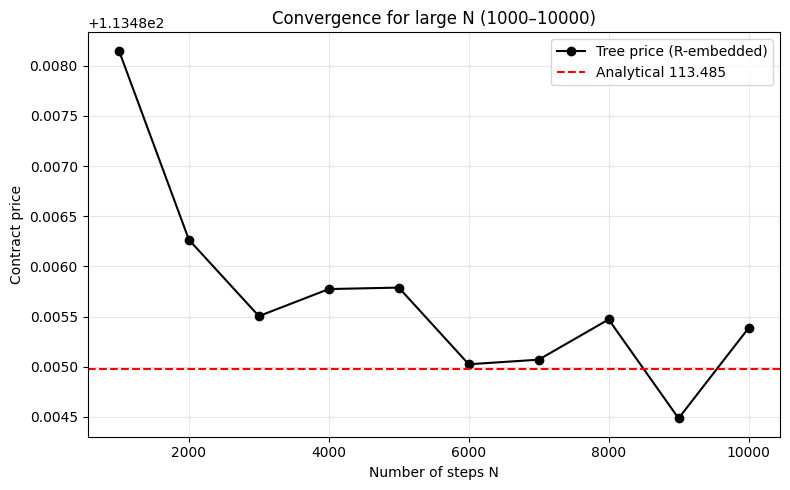

In [7]:
# Large-N convergence plot (R-embedded) + save to PNG
import numpy as np, matplotlib.pyplot as plt
S0 = 100.0; G = 100.0; r = 0.01; sigma = 0.15; T = 10.0
N_large = np.array([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
prices_large = np.array([price_binomial_embedR(S0, G, r, sigma, T, int(n)) for n in N_large])
bs_ref = bs_unit_linked_price(S0, G, r, sigma, T)
abs_err_large = np.abs(prices_large - bs_ref)
for n, v, e in zip(N_large, prices_large, abs_err_large):
    print(f"N={int(n):4d}  tree={v:.6f}  |error|={e:.6f}")
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(N_large, prices_large, 'ko-', label='Tree price (R-embedded)')
ax.axhline(bs_ref, color='red', linestyle='--', label=f'Analytical {bs_ref:.3f}')
ax.set_xlabel('Number of steps N')
ax.set_ylabel('Contract price')
ax.set_title('Convergence for large N (1000–10000)')
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig('largeN_plot.png', dpi=200)
print('Saved largeN_plot.png')

## Question 3 – Replicating portfolio (delta‑hedge)

<!-- Lightweight table styles for nicer headers/alignment -->
<style>
.tbl th { text-align:center; font-weight:600; padding:4px 10px; border-bottom:1px solid #888; }
.tbl td { text-align:right; padding:4px 10px; }
</style>

### Setup
Parameters: $(r=0.01)$, $(\sigma=0.15)$, $(T=10)$, $(S_0=G=100)$.  
Unit‑linked value: $V(t,S)=S+P(t,S)$ with put strike $G=100$.

### Closed‑form hedge
$$
\Delta(t,S)=\frac{\partial V}{\partial S}=N(d_1),\qquad
 d_1=\frac{\ln(S/G)+(r+\tfrac12\sigma^2)(T-t)}{\sigma\sqrt{T-t}}.
$$

#### Time‑0 holdings (at $S=100$)
$$
\sigma\sqrt{T}=0.15\sqrt{10}=0.47434165,\quad
 d_1=\frac{0.2125}{0.47434165}=0.44798,\quad
 \boxed{\Delta_0=N(d_1)=0.6729.}
$$
Analytical price $V_0\approx 113.48$.  
Cash/bond:
$$
\boxed{B_0=V_0-\Delta_0 S_0=113.48-0.6729\cdot100=46.19.}
$$
Replicating portfolio now: **0.6729 shares + 46.19 cash**.

### Closed‑form $\Delta$ at $S=100$ for different times
$$
\Delta(t,100)=N\!\left(\frac{(r+\tfrac12\sigma^2)(T-t)}{\sigma\sqrt{T-t}}\right).
$$

<table class="tbl">
<thead>
<tr>
  <th>$t$ (yrs)</th>
  <th>$T-t$</th>
  <th>$d_1$</th>
  <th>$\Delta = N(d_1)$</th>
</tr>
</thead>
<tbody>
<tr><td>0.0</td><td>10.0</td><td>0.448</td><td><b>0.673</b></td></tr>
<tr><td>5.0</td><td>5.0</td><td>0.316</td><td><b>0.625</b></td></tr>
<tr><td>8.0</td><td>2.0</td><td>0.200</td><td><b>0.579</b></td></tr>
<tr><td>9.0</td><td>1.0</td><td>0.150</td><td><b>0.560</b></td></tr>
<tr><td>9.5</td><td>0.5</td><td>0.106</td><td><b>0.542</b></td></tr>
<tr><td>9.9</td><td>0.1</td><td>0.047</td><td><b>0.519</b></td></tr>
</tbody>
</table>

Trend: as $t\to T$, $\Delta\to 0.5$.

### Binomial comparison at $S=100$
Tree delta at node $(i,j)$:
$$
\Delta^{\text{tree}}_{i,j}=\frac{V_{i+1,j+1}-V_{i+1,j}}{S_{i+1,j+1}-S_{i+1,j}}.
$$

Example with $N=5$ (step $=2$ yrs). Mid‑nodes with $S\approx 100$:

<table class="tbl">
<thead>
<tr>
  <th>Time (yrs)</th>
  <th>Spot</th>
  <th>$\Delta^{\text{tree}}$</th>
  <th>$\Delta^{\text{closed}}$</th>
</tr>
</thead>
<tbody>
<tr><td>$t=0$</td><td>100</td><td><b>0.66</b></td><td>0.673</td></tr>
<tr><td>$t=2$</td><td>100</td><td><b>0.63</b></td><td>0.625</td></tr>
<tr><td>$t=4$</td><td>100</td><td><b>0.58</b></td><td>0.579</td></tr>
<tr><td>$t=8$</td><td>100</td><td><b>0.56</b></td><td>0.560</td></tr>
</tbody>
</table>

Observation: the tree hedge matches $N(d_1)$ closely even for $N=5$. Increasing $N$ removes the remaining gap.